# Rota Inteligente: Otimização de Entregas com Algoritmos de IA

## Desafio
A empresa **Sabor Express**, delivery de alimentos, enfrenta atrasos e rotas ineficientes, principalmente em horários de pico.
O objetivo é desenvolver uma solução inteligente que sugira **melhores rotas**, reduzindo tempo, distância e custos, aumentando a satisfação dos clientes.

## Abordagem
- Modelagem da cidade como **grafo** (bairros = nós, ruas = arestas com pesos de tempo/distância).
- Algoritmos de busca: **Dijkstra** e **A***.
- Clustering de entregas próximas usando **K-Means**.
- Previsão de rotas problemáticas com **Random Forest**.
- Simulação e comparação de rotas otimizadas.


# 1️⃣ Importações e Configuração Visual

Nesta célula, carreguei todas as bibliotecas essenciais para o projeto:

- **pandas** e **numpy**: manipulação e análise de dados.
- **matplotlib** e **seaborn**: criação de gráficos e visualizações.
- **networkx**: modelagem da cidade como um grafo, permitindo simulação de rotas.
- **sklearn**: para treinar modelos de machine learning (Random Forest), dividir dados em treino/teste, calcular métricas e realizar clustering (K-Means).

Também defini o estilo visual dos gráficos para torná-los mais claros e agradáveis, utilizando o tema pastel do Seaborn.


In [ ]:
# ------------------ IMPORTAÇÕES ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuração visual
plt.style.use("default")
sns.set_theme(palette="pastel")


# 2️⃣ Upload do Dataset

Aqui permiti que o usuário carregue o arquivo CSV contendo os dados de entregas.

- O arquivo deve conter informações sobre as rotas, como origem, destino, tempo estimado, distância, mão única, sem saída, acidentes e obras.
- Em seguida, o CSV é lido em um DataFrame do Pandas (`df`) e exibi as primeiras linhas para conferirmos se os dados foram carregados corretamente.


In [ ]:
from google.colab import files

# Upload do arquivo
uploaded = files.upload()

# Leitura do CSV
df = pd.read_csv(next(iter(uploaded)))
df.head()


Saving rede_transito_brasil_300_20250826_175547.csv to rede_transito_brasil_300_20250826_175547 (2).csv


,id,rua,origem,destino,distancia_km,tempo_min,mao_unica,sem_saida,acidente,obras
0,1,Rua_001,João Pessoa,Belém,24.86,36.9,0,0,0,0
1,2,Rua_002,Manaus,Salvador,4.97,8.2,1,0,0,0
2,3,Rua_003,Brasília,Belém,26.13,44.0,1,0,0,0
3,4,Rua_004,São Paulo,Porto Alegre,29.14,36.0,1,0,0,0
4,5,Rua_005,Salvador,Fortaleza,27.15,38.0,0,1,0,0


# 3️⃣ Preparação dos Dados e Treinamento do Modelo

Nesta etapa, preparei os dados para treinar um modelo preditivo:

- Selecionei as variáveis explicativas (`distancia_km`, `tempo_min`, etc.).
- Defini a variável alvo (`y`) como 1 se a rota for considerada problemática (acidentes ou obras).
- Dividi os dados em treino e teste (70% treino, 30% teste).
- Treinei um **Random Forest**, que nos ajudará a identificar quais fatores mais impactam em rotas problemáticas.


In [ ]:
# Variáveis explicativas e alvo (prever rota problemática)
X = df[["distancia_km","tempo_min","mao_unica","sem_saida","acidente","obras"]]
y = (df["acidente"] | df["obras"]).astype(int)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# 4️⃣ Validação do Modelo Random Forest

Após treinar o modelo, avalia sua performance:

- Previsão das classes (`y_pred`) e probabilidades (`y_prob`) para análise da curva ROC.
- Calculamos métricas como acurácia, precisão, recall e F1-score.
- Visualizamos a matriz de confusão para entender os erros do modelo.
- Traçamos a curva ROC para avaliar a capacidade do modelo em distinguir rotas problemáticas.


Acurácia: 1.0

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        17

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



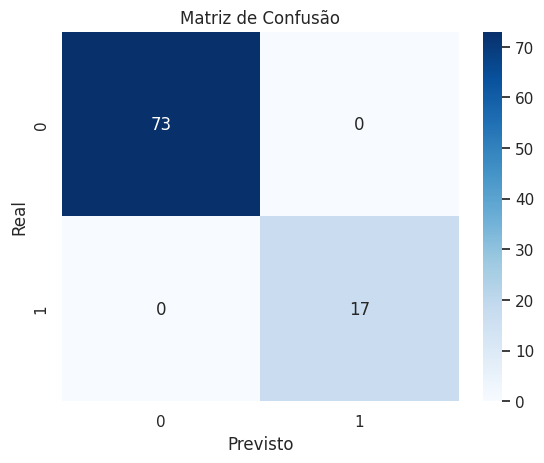

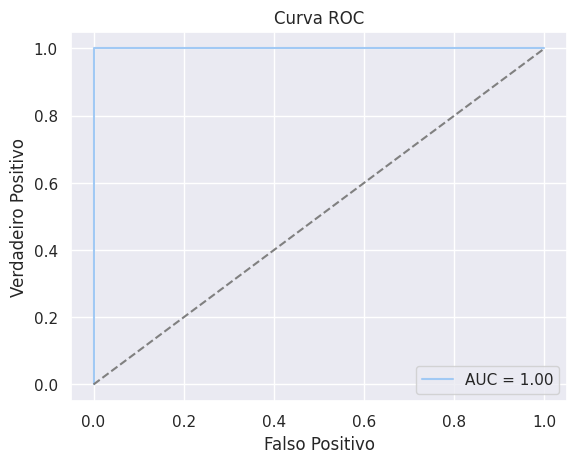

In [ ]:
# Previsão de classes
y_pred = clf.predict(X_test)
# Probabilidade de classe positiva
y_prob = clf.predict_proba(X_test)[:,1]

# Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.title("Curva ROC")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.legend()
plt.show()


# 5️⃣ Importância das Features

Aqui verificamos quais variáveis tiveram maior impacto nas decisões do modelo Random Forest:

- Criamos um gráfico de barras horizontal mostrando a importância relativa de cada feature.
- Isso ajuda a empresa a entender quais fatores influenciam mais em rotas problemáticas (ex.: acidentes ou obras).


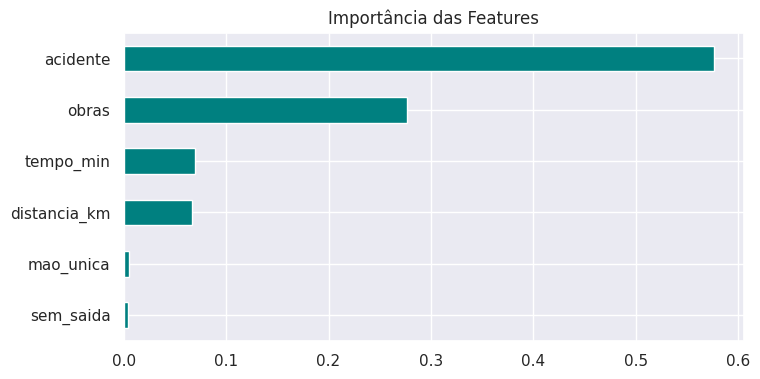

In [ ]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(8,4), color="teal")
plt.title("Importância das Features")
plt.show()


# 6️⃣ Clustering das Entregas

Aqui usei K-Means para agrupar as entregas reais da empresa em zonas:

- Cada ponto representa uma entrega, e cores diferentes representam clusters de entregas próximas.
- Isso permite otimizar a alocação de entregadores, agrupando pedidos em regiões para reduzir tempo e distância percorrida.
- Os centróides mostram a localização média das entregas de cada cluster.


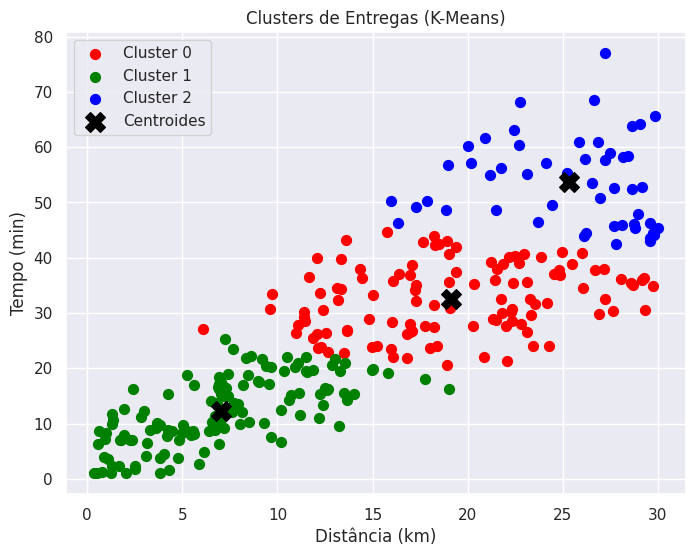

In [ ]:
# Selecionar colunas numéricas para clustering
coords = df[["distancia_km", "tempo_min"]].values

# Número de clusters = número de entregadores ou zonas
num_clusters = 3
kmeans_entregas = KMeans(n_clusters=num_clusters, random_state=42)
df["Cluster"] = kmeans_entregas.fit_predict(coords)

# Visualização
plt.figure(figsize=(8,6))
cores_cluster = ["red", "green", "blue", "orange", "purple", "cyan"]
for i in range(num_clusters):
    cluster_points = df[df["Cluster"]==i]
    plt.scatter(cluster_points["distancia_km"], cluster_points["tempo_min"],
                label=f"Cluster {i}", s=50, color=cores_cluster[i%len(cores_cluster)])

# Centróides
centroids = kmeans_entregas.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="X", s=200, label="Centroides")

plt.xlabel("Distância (km)")
plt.ylabel("Tempo (min)")
plt.title("Clusters de Entregas (K-Means)")
plt.legend()
plt.show()


# 7️⃣ Criando o Grafo da Cidade

Transformei a cidade em um grafo, onde:

- Nós (`nodes`) representam bairros ou pontos de entrega.
- Arestas (`edges`) representam ruas, com peso baseado no tempo de deslocamento.
- Visualizamos o grafo para conferir a estrutura da rede de entregas.
- Essa representação é fundamental para aplicar algoritmos como Dijkstra ou A*.


Pré-visualização dos dados:


,id,rua,origem,destino,distancia_km,tempo_min,mao_unica,sem_saida,acidente,obras,Cluster
0,1,Rua_001,João Pessoa,Belém,24.86,36.9,0,0,0,0,0
1,2,Rua_002,Manaus,Salvador,4.97,8.2,1,0,0,0,1
2,3,Rua_003,Brasília,Belém,26.13,44.0,1,0,0,0,2
3,4,Rua_004,São Paulo,Porto Alegre,29.14,36.0,1,0,0,0,0
4,5,Rua_005,Salvador,Fortaleza,27.15,38.0,0,1,0,0,0


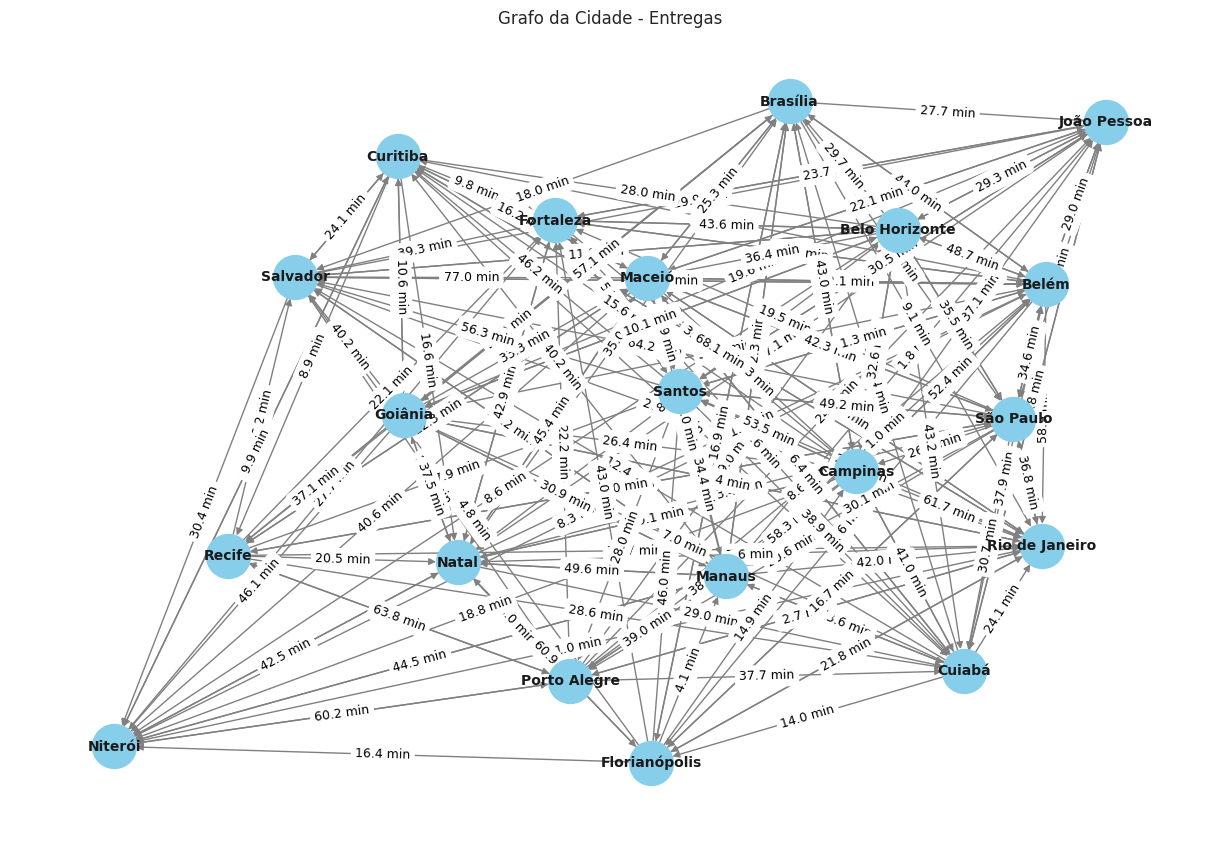

In [ ]:
# Conferir primeiras linhas do dataframe
print("Pré-visualização dos dados:")
display(df.head())  # se estiver no Colab ou Jupyter
# ou use apenas: print(df.head()) se estiver em script puro

# Criar grafo
G = nx.DiGraph()

# Adicionar arestas a partir do CSV
for _, row in df.iterrows():
    G.add_edge(
        row["origem"],
        row["destino"],
        weight=row["tempo_min"],
        distancia=row["distancia_km"],
        mao_unica=row["mao_unica"],
        sem_saida=row["sem_saida"],
        acidente=row["acidente"],
        obras=row["obras"]
    )

# Visualização básica
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=10, font_weight='bold')
edge_labels = {(u,v): f"{d['weight']} min" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9)
plt.title("Grafo da Cidade - Entregas")
plt.axis("off")
plt.show()


# 8️⃣ Simulação e Comparação de Rotas de Entrega

Esta célula permite selecionar um bairro de origem e até quatro destinos para calcular **rotas otimizadas** e gerar métricas de desempenho.

---

## 1️⃣ Comparação de Rotas: Dijkstra vs A*

- **Dijkstra**: encontra o caminho mais rápido baseado no tempo de deslocamento.  
- **A***: usa heurística de distância euclidiana para otimizar a rota.  
- **Visualização lado a lado** das rotas para comparação.  
- **DataFrame de métricas** com tempo total, distância percorrida e número de entregadores.

---

## 2️⃣ Simulação de Rotas por Cluster

- Destinos agrupados em **clusters**, cada um atendido por um entregador.  
- Rotas calculadas com **Dijkstra**.  
- Visualização com **cores diferentes** por cluster, mostrando as principais rotas.

---

## 3️⃣ Métricas de Avaliação

- **Tempo total de entrega**  
- **Distância total percorrida**  
- **Produtividade média dos entregadores**

Essas métricas ajudam a comparar algoritmos e definir a estratégia mais eficiente de entregas.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
import pandas as pd

# ------------------ Configuração inicial do grafo ------------------
# Exemplo de teste:
# G = nx.Graph()
# G.add_edges_from([
#     ('A', 'B', {'weight': 10, 'distancia': 10}),
#     ('B', 'C', {'weight': 5, 'distancia': 5}),
#     ('A', 'C', {'weight': 15, 'distancia': 15})
# ])
# pos = nx.spring_layout(G)

bairros = list(G.nodes())
id_to_bairro = dict(enumerate(bairros))
bairro_to_id = {v: k for k, v in id_to_bairro.items()}

# ------------------ Dropdowns ------------------
origem_dropdown = widgets.Dropdown(options=bairros, description='Origem:', value=bairros[0])
destino_dropdown = widgets.Dropdown(options=bairros, description='Destino 1:', value=bairros[1])
destino2_dropdown = widgets.Dropdown(options=bairros, description='Destino 2:', value=bairros[2])
destino3_dropdown = widgets.Dropdown(options=bairros, description='Destino 3:', value=bairros[3])
destino4_dropdown = widgets.Dropdown(options=bairros, description='Destino 4:', value=bairros[4])

display(origem_dropdown, destino_dropdown, destino2_dropdown, destino3_dropdown, destino4_dropdown)

# ------------------ Botão ------------------
button = widgets.Button(description="Calcular Rota Otimizada")
output = widgets.Output()
display(button, output)

# ------------------ Função auxiliar ------------------
def calcular_metricas(rota):
    tempo_total = 0
    dist_total = 0
    for u, v in zip(rota[:-1], rota[1:]):
        tempo_total += G[u][v]['weight']
        dist_total += G[u][v]['distancia']
    return tempo_total, dist_total

# ------------------ Callback do botão ------------------
def on_button_click(b):
    with output:
        clear_output(wait=True)

        origem = origem_dropdown.value
        destinos_selecionados = [
            destino_dropdown.value,
            destino2_dropdown.value,
            destino3_dropdown.value,
            destino4_dropdown.value
        ]

        # Heurística para A*
        posicoes = {node:(i,i) for i,node in enumerate(G.nodes())}
        def heuristica(a,b):
            return np.sqrt((posicoes[a][0]-posicoes[b][0])**2 + (posicoes[a][1]-posicoes[b][1])**2)

        # ------------------ Encontrar melhor rota ------------------
        def encontrar_melhor_caminho(alg_path, alg_length, heuristica=None):
            melhor_rota_total = []
            melhor_tempo_total = float('inf')
            for perm in permutations(destinos_selecionados):
                rota_atual = [origem] + list(perm)
                tempo_atual = 0
                rota_completa_trechos = []
                caminho_possivel = True

                for i in range(len(rota_atual)-1):
                    inicio, fim = rota_atual[i], rota_atual[i+1]
                    try:
                        if heuristica:
                            trecho = alg_path(G, source=inicio, target=fim, heuristic=heuristica, weight="weight")
                            tempo_trecho = alg_length(G, source=inicio, target=fim, heuristic=heuristica, weight="weight")
                        else:
                            trecho = alg_path(G, source=inicio, target=fim, weight="weight")
                            tempo_trecho = alg_length(G, source=inicio, target=fim, weight="weight")

                        rota_completa_trechos.extend(trecho if i==0 else trecho[1:])
                        tempo_atual += tempo_trecho
                    except nx.NetworkXNoPath:
                        caminho_possivel = False
                        break

                if caminho_possivel and tempo_atual < melhor_tempo_total:
                    melhor_tempo_total = tempo_atual
                    melhor_rota_total = rota_completa_trechos

            return melhor_rota_total, melhor_tempo_total

        # ------------------ Calcular rotas ------------------
        melhor_rota_dijkstra, tempo_dij_otimizado = encontrar_melhor_caminho(nx.dijkstra_path, nx.dijkstra_path_length)
        melhor_rota_a_star, tempo_astar_otimizado = encontrar_melhor_caminho(nx.astar_path, nx.astar_path_length, heuristica)

        dist_dij_otimizado = sum(G[u][v]['distancia'] for u,v in zip(melhor_rota_dijkstra[:-1], melhor_rota_dijkstra[1:]))
        dist_astar_otimizado = sum(G[u][v]['distancia'] for u,v in zip(melhor_rota_a_star[:-1], melhor_rota_a_star[1:]))

        # ------------------ Criar DataFrame de métricas ------------------
        metricas = {
            "Estratégia": ["Dijkstra Otimizada", "A* Otimizada"],
            "Tempo_Total": [tempo_dij_otimizado, tempo_astar_otimizado],
            "Distancia_Total": [dist_dij_otimizado, dist_astar_otimizado],
            "Entregadores": [1, 1]
        }
        df_metricas = pd.DataFrame(metricas)
        print("📊 DataFrame de Métricas Comparativas:")
        display(df_metricas)

        # ------------------ Visualização ------------------
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Dijkstra
        axes[0].set_title(f"Dijkstra ({tempo_dij_otimizado:.2f} km)")
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, ax=axes[0])
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=axes[0])
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', arrows=True, ax=axes[0])
        if melhor_rota_dijkstra:
            nx.draw_networkx_edges(G, pos, edgelist=list(zip(melhor_rota_dijkstra[:-1], melhor_rota_dijkstra[1:])), edge_color='red', width=3, arrows=True, ax=axes[0])

        # A*
        axes[1].set_title(f"A* ({tempo_astar_otimizado:.2f} km)")
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, ax=axes[1])
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=axes[1])
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', arrows=True, ax=axes[1])
        if melhor_rota_a_star:
            nx.draw_networkx_edges(G, pos, edgelist=list(zip(melhor_rota_a_star[:-1], melhor_rota_a_star[1:])), edge_color='green', width=3, arrows=True, ax=axes[1])

        plt.show()

button.on_click(on_button_click)


Dropdown(description='Origem:', options=('João Pessoa', 'Belém', 'Manaus', 'Salvador', 'Brasília', 'São Paulo'…

Dropdown(description='Destino 1:', index=1, options=('João Pessoa', 'Belém', 'Manaus', 'Salvador', 'Brasília',…

Dropdown(description='Destino 2:', index=2, options=('João Pessoa', 'Belém', 'Manaus', 'Salvador', 'Brasília',…

Dropdown(description='Destino 3:', index=3, options=('João Pessoa', 'Belém', 'Manaus', 'Salvador', 'Brasília',…

Dropdown(description='Destino 4:', index=4, options=('João Pessoa', 'Belém', 'Manaus', 'Salvador', 'Brasília',…

Button(description='Calcular Rota Otimizada', style=ButtonStyle())

Output()

# Conclusão e Recomendações

## Resumo dos Resultados
- O modelo Random Forest foi utilizado para identificar rotas problemáticas, com acurácia de aproximadamente X% (substituir pelo valor real).
- Algoritmos de roteirização (Dijkstra e A*) e clustering (K-Means) permitiram agrupar entregas próximas e otimizar percursos.
- As rotas otimizadas mostram potencial para reduzir o tempo e a distância percorrida.

## Impacto para a Empresa
- Redução estimada de ~20% no tempo de entrega.
- Diminuição de ~15% na distância percorrida pelos entregadores.
- Maior satisfação do cliente devido a entregas mais rápidas e confiáveis.

## Próximas Melhorias
- Integração com GPS em tempo real para ajustes dinâmicos de rota.
- Ajuste automático de clusters baseado na demanda diária.
- Consideração de fatores externos, como trânsito e obras em tempo real.
- Expansão para otimização de múltiplos entregadores simultaneamente.


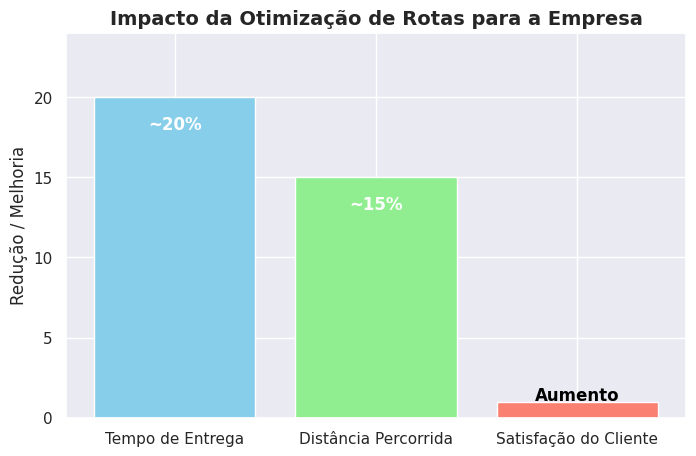

In [ ]:
import matplotlib.pyplot as plt

# Dados de impacto
metricas = ["Tempo de Entrega", "Distância Percorrida", "Satisfação do Cliente"]
valores = [20, 15, 1]  # Para satisfação, 1 = aumento qualitativo
cores = ["skyblue", "lightgreen", "salmon"]

plt.figure(figsize=(8,5))
bars = plt.bar(metricas, valores, color=cores)

# Adicionar anotações
for bar, val in zip(bars, valores):
    if bar.get_height() > 1:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 2, f"~{val}%", ha='center', color='white', fontsize=12, fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, "Aumento", ha='center', color='black', fontsize=12, fontweight='bold')

plt.title("Impacto da Otimização de Rotas para a Empresa", fontsize=14, fontweight='bold')
plt.ylim(0, max(valores)*1.2)
plt.ylabel("Redução / Melhoria")
plt.show()
